✅ Model loaded for evaluation!
✅ Test Loss: 0.1750
✅ Test Accuracy: 0.9513
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Classification Report:

              precision    recall  f1-score   support

       Anger       0.95      0.97      0.96       310
        Fear       0.95      0.95      0.95       314
         Joy       0.97      0.96      0.97       310
     Neutral       0.96      0.94      0.95       272
     Sadness       0.93      0.94      0.94       314

    accuracy                           0.95      1520
   macro avg       0.95      0.95      0.95      1520
weighted avg       0.95      0.95      0.95      1520

✅ Evaluation metrics and classification report saved at: C:\Users\Shimra\Desktop\EmotiSense\evaluated\evaluation_metrics.txt
✅ Evaluation predictions saved at: C:\Users\Shimra\Desktop\EmotiSense\evaluated\evaluation_predictions.csv
✅ Confusion matrix CSV saved at: C:\Users\Shimra\Desktop\EmotiSense\evaluated\confusion_matrix.csv


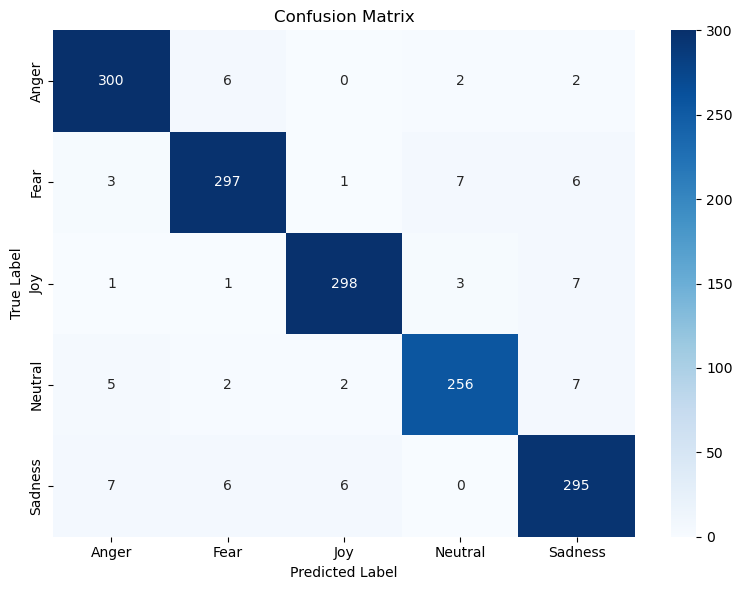

✅ Confusion matrix plot saved at: C:\Users\Shimra\Desktop\EmotiSense\evaluated\confusion_matrix.png


In [1]:
# ---------------------------
# 0. Imports
# ---------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import pickle
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Paths
# ---------------------------
trained_dir = r"C:\Users\Shimra\Desktop\EmotiSense\trained"
evaluated_dir = r"C:\Users\Shimra\Desktop\EmotiSense\evaluated"
os.makedirs(evaluated_dir, exist_ok=True)

test_file = r"C:\Users\Shimra\Desktop\EmotiSense\processed\emotion_augmented.csv"

# ---------------------------
# 2. Load Test Data
# ---------------------------
df = pd.read_csv(test_file)
df['text'] = df['text'].astype(str)
messages = df['text'].values
labels = df['emotion'].values

# ---------------------------
# 3. Load Label Encoder & TF-IDF
# ---------------------------
with open(os.path.join(trained_dir, "label_encoder.pkl"), 'rb') as f:
    le = pickle.load(f)

with open(os.path.join(trained_dir, "tfidf_vectorizer.pkl"), 'rb') as f:
    tfidf = pickle.load(f)

# ---------------------------
# 4. Transform messages
# ---------------------------
X_tfidf = tfidf.transform(messages).toarray()
y_true_int = le.transform(labels)
y_true_onehot = pd.get_dummies(y_true_int).values

# ---------------------------
# 5. Load Trained Model
# ---------------------------
model = load_model(os.path.join(trained_dir, "baseline_model.keras"))
print("✅ Model loaded for evaluation!")

# ---------------------------
# 6. Evaluate Model
# ---------------------------
loss, accuracy = model.evaluate(X_tfidf, y_true_onehot, verbose=0)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

# ---------------------------
# 7. Predictions
# ---------------------------
y_pred_prob = model.predict(X_tfidf)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_pred_labels = le.inverse_transform(y_pred_int)

# ---------------------------
# 8. Classification Report
# ---------------------------
report = classification_report(y_true_int, y_pred_int, target_names=le.classes_)
print("\n✅ Classification Report:\n")
print(report)

# Save metrics & report to text file
metrics_file = os.path.join(evaluated_dir, "evaluation_metrics.txt")
with open(metrics_file, "w") as f:
    f.write(f"Test Loss: {loss:.4f}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)
print(f"✅ Evaluation metrics and classification report saved at: {metrics_file}")

# ---------------------------
# 9. Save Predictions
# ---------------------------
pred_df = pd.DataFrame({
    'text': messages,
    'true_label': labels,
    'predicted_label': y_pred_labels
})
pred_df.to_csv(os.path.join(evaluated_dir, "evaluation_predictions.csv"), index=False)
print(f"✅ Evaluation predictions saved at: {os.path.join(evaluated_dir, 'evaluation_predictions.csv')}")

# ---------------------------
# 10. Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_true_int, y_pred_int)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Save as CSV
cm_df.to_csv(os.path.join(evaluated_dir, "confusion_matrix.csv"))
print(f"✅ Confusion matrix CSV saved at: {os.path.join(evaluated_dir, 'confusion_matrix.csv')}")

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(os.path.join(evaluated_dir, "confusion_matrix.png"))
plt.show()
print(f"✅ Confusion matrix plot saved at: {os.path.join(evaluated_dir, 'confusion_matrix.png')}")

